# Follow-Me Project
Congratulations on reaching the final project of the Robotics Nanodegree! 

Previously, you worked on the Semantic Segmentation lab where you built a deep learning network that locates a particular human target within an image. For this project, you will utilize what you implemented and learned from that lab and extend it to train a deep learning model that will allow a simulated quadcopter to follow around the person that it detects! 

Most of the code below is similar to the lab with some minor modifications. You can start with your existing solution, and modify and improve upon it to train the best possible model for this task.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with a starting dataset for this project. Download instructions can be found in the README for this project's repo.
Alternatively, you can collect additional data of your own to improve your model. Check out the "Collecting Data" section in the Project Lesson in the Classroom for more details!

In [93]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models
from tensorflow.contrib.keras.python.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard, ModelCheckpoint

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers <a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network (FCN). The following code will introduce you to the functions that you need to build your semantic segmentation model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers, due to their advantages as explained in the classroom. The 1x1 convolution layer in the FCN, however, is a regular convolution. Implementations for both are provided below for your use. Each includes batch normalization with the ReLU activation function applied to the layers. 

In [2]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function implements the bilinear upsampling layer. Upsampling by a factor of 2 is generally recommended, but you can try out different factors as well. Upsampling is used in the decoder block of the FCN.

In [3]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model <a id='build'></a>
In the following cells, you will build an FCN to train a model to detect and locate the hero target within an image. The steps are:
- Create an `encoder_block`
- Create a `decoder_block`
- Build the FCN consisting of encoder block(s), a 1x1 convolution, and decoder block(s).  This step requires experimentation with different numbers of layers and filter sizes to build your model.

### Encoder Block
Create an encoder block that includes a separable convolution layer using the `separable_conv2d_batchnorm()` function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [4]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    return output_layer

### Decoder Block
The decoder block is comprised of three parts:
- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [154]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    ups = bilinear_upsample(small_ip_layer)
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    cat = layers.concatenate([ups, large_ip_layer])
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(cat, filters)
    output_layer = separable_conv2d_batchnorm(output_layer, filters)
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, go ahead and build your FCN architecture! 

There are three steps:
- Add encoder blocks to build the encoder layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add a 1x1 Convolution layer using the conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for the decoder layers.

In [157]:
def showShape( mlayer, name = '' ) :
    print( name + ' : ', mlayer.get_shape().as_list() )

def fcn_model(inputs, num_classes):
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    enc1 = encoder_block(inputs, 8, 1)
    enc2 = encoder_block(enc1, 8, 2)
    enc2 = encoder_block(enc2, 16, 1)
    #pol2 = layers.MaxPooling2D()(enc1)
    enc3 = encoder_block(enc2, 16, 2)
    enc3 = encoder_block(enc3, 32, 1)
    #pol3 = layers.MaxPooling2D()(enc2)
    enc4 = encoder_block(enc3, 3, 1)
    #pool2 = layers.MaxPooling2D()(enc2)
    
    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    #conv = conv2d_batchnorm(inputs, 50, kernel_size=1)
    #conv = layers.Dropout(0.5)(conv)
    #showShape(conv, 'conv')
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    x = layers.concatenate([enc3, enc4])    
    x = decoder_block(x, enc2, 3)
    #x = layers.concatenate([x, pol2]) 
    x = decoder_block(x, enc1, 3)
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 1, activation='softmax', padding='same')(x)

## Training <a id='training'></a>
The following cells will use the FCN you created and define an ouput layer based on the size of the processed image and the number of classes recognized. You will define the hyperparameters to compile and train your model.

Please Note: For this project, the helper code in `data_iterator.py` will resize the copter images to 160x160x3 to speed up training.

In [158]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 160
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [159]:
learning_rate = 0.007
batch_size = 32
num_epochs = 100
decay_rate = 0#learning_rate / num_epochs / 4
steps_per_epoch = 35
validation_steps = 10
workers = 2

Epoch 1/100
34/35 [============================>.] - ETA: 0s - loss: 0.0296

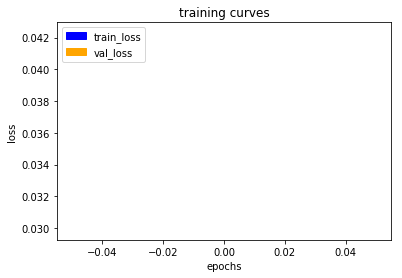

Epoch 00000: val_loss improved from inf to 0.04234, saving model to ../model/0.0423.hdf5
35/35 [==============================] - 24s - loss: 0.0299 - val_loss: 0.0423
Epoch 2/100
34/35 [============================>.] - ETA: 0s - loss: 0.0270

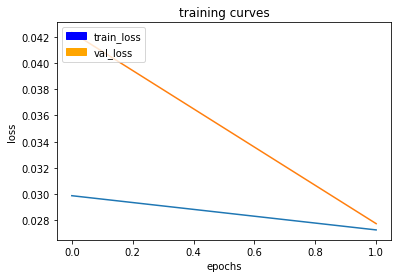

Epoch 00001: val_loss improved from 0.04234 to 0.02775, saving model to ../model/0.0278.hdf5
35/35 [==============================] - 24s - loss: 0.0273 - val_loss: 0.0278
Epoch 3/100
34/35 [============================>.] - ETA: 0s - loss: 0.0266

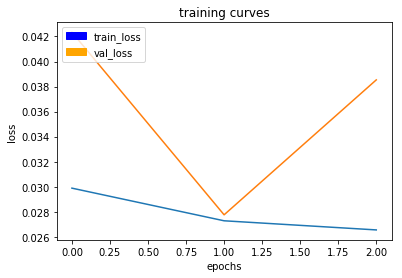

Epoch 00002: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0265 - val_loss: 0.0385
Epoch 4/100
34/35 [============================>.] - ETA: 0s - loss: 0.0279

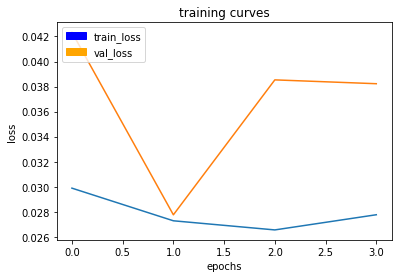

Epoch 00003: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0278 - val_loss: 0.0382
Epoch 5/100
34/35 [============================>.] - ETA: 0s - loss: 0.0286

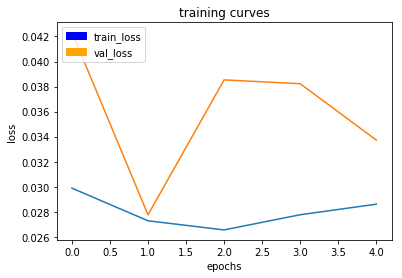

Epoch 00004: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0286 - val_loss: 0.0337
Epoch 6/100
34/35 [============================>.] - ETA: 0s - loss: 0.0278

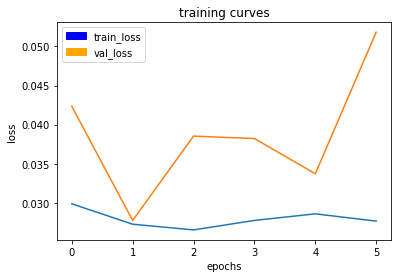

Epoch 00005: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0277 - val_loss: 0.0518
Epoch 7/100
34/35 [============================>.] - ETA: 0s - loss: 0.0316

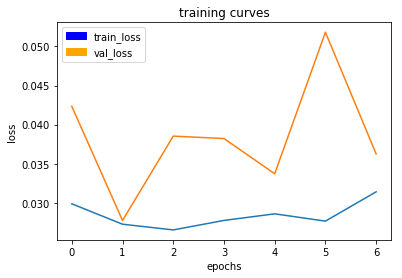

Epoch 00006: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0314 - val_loss: 0.0363
Epoch 8/100
34/35 [============================>.] - ETA: 0s - loss: 0.0273

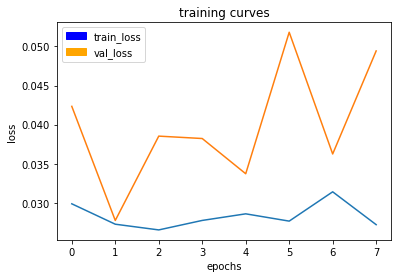

Epoch 00007: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0494
Epoch 9/100
34/35 [============================>.] - ETA: 0s - loss: 0.0275

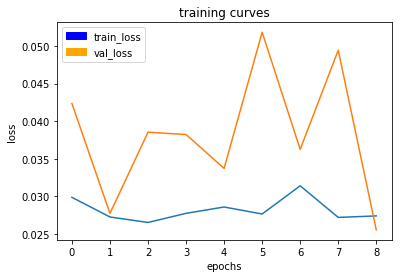

Epoch 00008: val_loss improved from 0.02775 to 0.02556, saving model to ../model/0.0256.hdf5
35/35 [==============================] - 24s - loss: 0.0274 - val_loss: 0.0256
Epoch 10/100
34/35 [============================>.] - ETA: 0s - loss: 0.0277

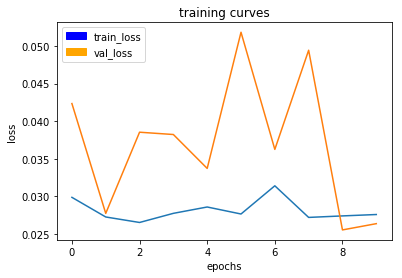

Epoch 00009: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0276 - val_loss: 0.0264
Epoch 11/100
34/35 [============================>.] - ETA: 0s - loss: 0.0254

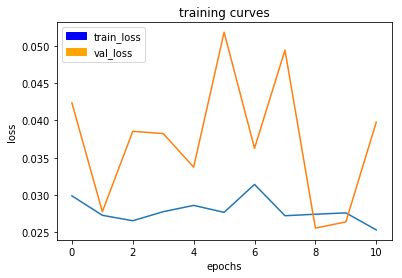

Epoch 00010: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0253 - val_loss: 0.0398
Epoch 12/100
34/35 [============================>.] - ETA: 0s - loss: 0.0318

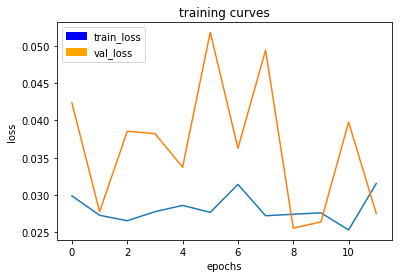

Epoch 00011: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0315 - val_loss: 0.0275
Epoch 13/100
34/35 [============================>.] - ETA: 0s - loss: 0.0273

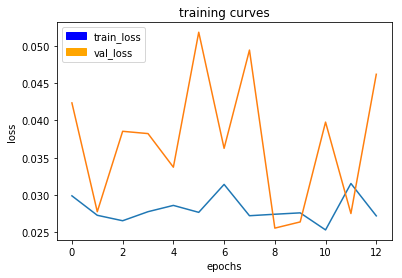

Epoch 00012: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0462
Epoch 14/100
34/35 [============================>.] - ETA: 0s - loss: 0.0254

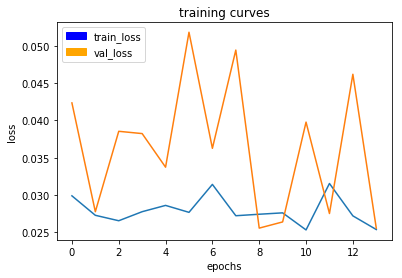

Epoch 00013: val_loss improved from 0.02556 to 0.02555, saving model to ../model/0.0255.hdf5
35/35 [==============================] - 24s - loss: 0.0254 - val_loss: 0.0255
Epoch 15/100
34/35 [============================>.] - ETA: 0s - loss: 0.0290

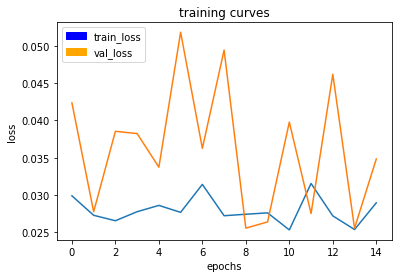

Epoch 00014: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0289 - val_loss: 0.0348
Epoch 16/100
34/35 [============================>.] - ETA: 0s - loss: 0.0284

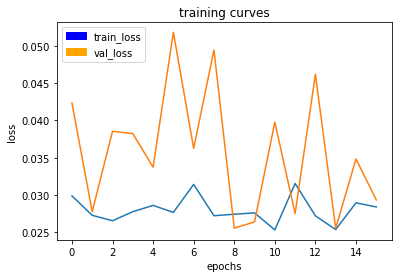

Epoch 00015: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0284 - val_loss: 0.0293
Epoch 17/100
34/35 [============================>.] - ETA: 0s - loss: 0.0306

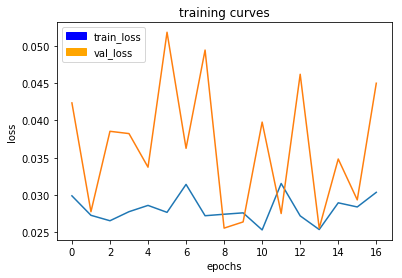


Epoch 00016: reducing learning rate to 0.0011468799784779549.
Epoch 00016: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0303 - val_loss: 0.0450
Epoch 18/100
34/35 [============================>.] - ETA: 0s - loss: 0.0291

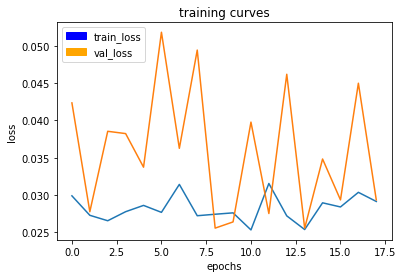

Epoch 00017: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0291 - val_loss: 0.0293
Epoch 19/100
34/35 [============================>.] - ETA: 0s - loss: 0.0264

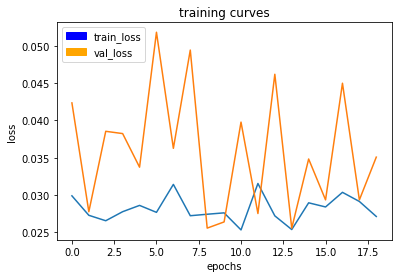

Epoch 00018: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0271 - val_loss: 0.0351
Epoch 20/100
34/35 [============================>.] - ETA: 0s - loss: 0.0258

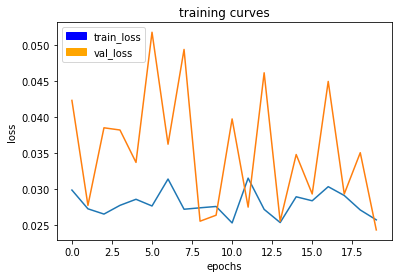

Epoch 00019: val_loss improved from 0.02555 to 0.02435, saving model to ../model/0.0243.hdf5
35/35 [==============================] - 25s - loss: 0.0257 - val_loss: 0.0243
Epoch 21/100
34/35 [============================>.] - ETA: 0s - loss: 0.0270

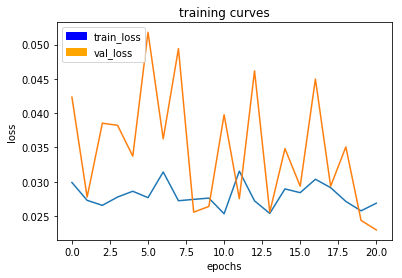

Epoch 00020: val_loss improved from 0.02435 to 0.02296, saving model to ../model/0.0230.hdf5
35/35 [==============================] - 24s - loss: 0.0269 - val_loss: 0.0230
Epoch 22/100
34/35 [============================>.] - ETA: 0s - loss: 0.0262

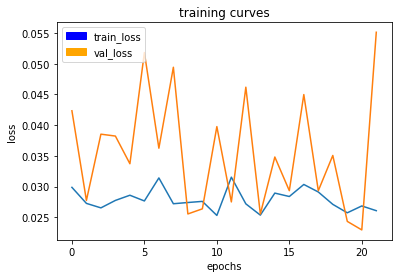

Epoch 00021: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0261 - val_loss: 0.0551
Epoch 23/100
34/35 [============================>.] - ETA: 0s - loss: 0.0304

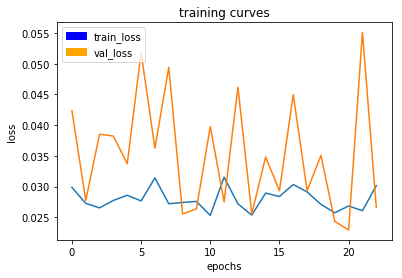

Epoch 00022: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0302 - val_loss: 0.0266
Epoch 24/100
34/35 [============================>.] - ETA: 0s - loss: 0.0259

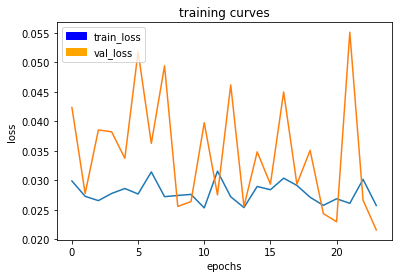

Epoch 00023: val_loss improved from 0.02296 to 0.02158, saving model to ../model/0.0216.hdf5
35/35 [==============================] - 24s - loss: 0.0257 - val_loss: 0.0216
Epoch 25/100
34/35 [============================>.] - ETA: 0s - loss: 0.0245

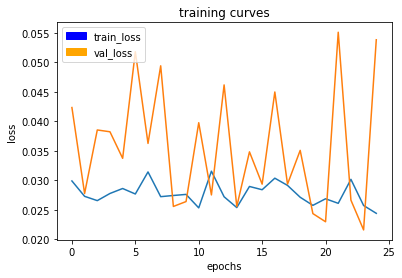

Epoch 00024: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0244 - val_loss: 0.0538
Epoch 26/100
34/35 [============================>.] - ETA: 0s - loss: 0.0268

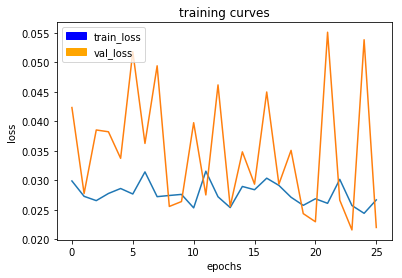

Epoch 00025: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0267 - val_loss: 0.0220
Epoch 27/100
34/35 [============================>.] - ETA: 0s - loss: 0.0293

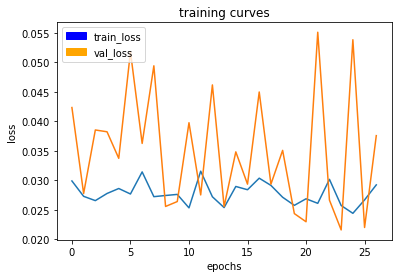

Epoch 00026: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0292 - val_loss: 0.0376
Epoch 28/100
34/35 [============================>.] - ETA: 0s - loss: 0.0282

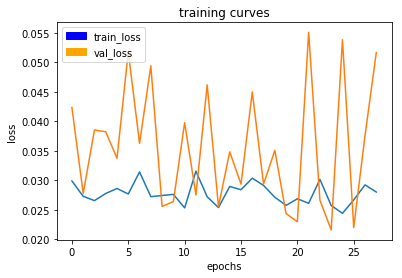

Epoch 00027: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0280 - val_loss: 0.0517
Epoch 29/100
34/35 [============================>.] - ETA: 0s - loss: 0.0246

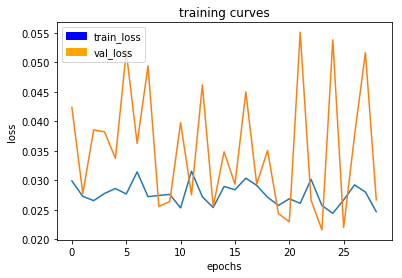

Epoch 00028: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0246 - val_loss: 0.0267
Epoch 30/100
34/35 [============================>.] - ETA: 0s - loss: 0.0274

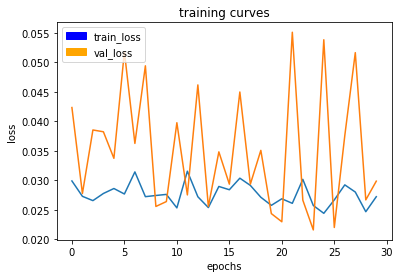

Epoch 00029: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0298
Epoch 31/100
34/35 [============================>.] - ETA: 0s - loss: 0.0271

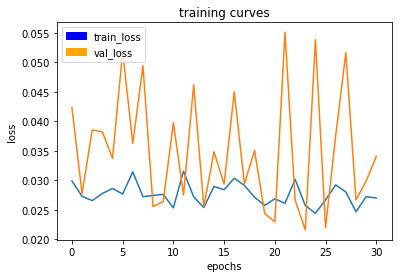

Epoch 00030: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0270 - val_loss: 0.0341
Epoch 32/100
34/35 [============================>.] - ETA: 0s - loss: 0.0293

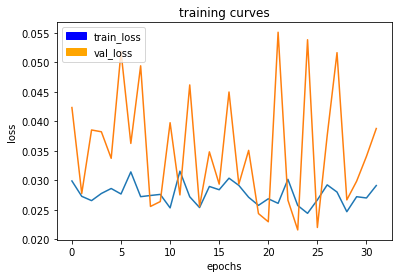


Epoch 00031: reducing learning rate to 0.0005734399892389774.
Epoch 00031: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0291 - val_loss: 0.0388
Epoch 33/100
34/35 [============================>.] - ETA: 0s - loss: 0.0250

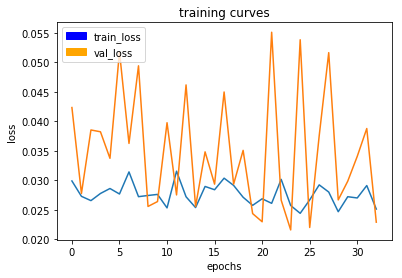

Epoch 00032: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0251 - val_loss: 0.0229
Epoch 34/100
34/35 [============================>.] - ETA: 0s - loss: 0.0284

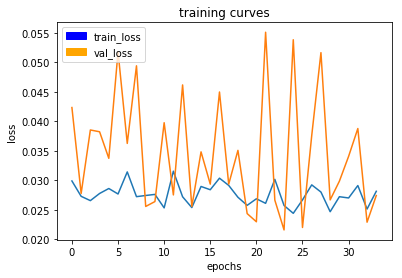

Epoch 00033: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0281 - val_loss: 0.0274
Epoch 35/100
34/35 [============================>.] - ETA: 0s - loss: 0.0286

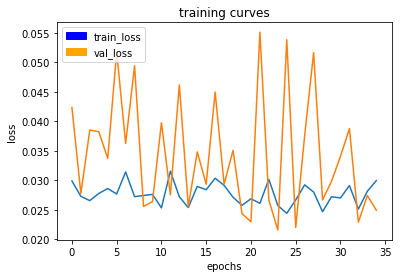

Epoch 00034: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0299 - val_loss: 0.0249
Epoch 36/100
34/35 [============================>.] - ETA: 0s - loss: 0.0237

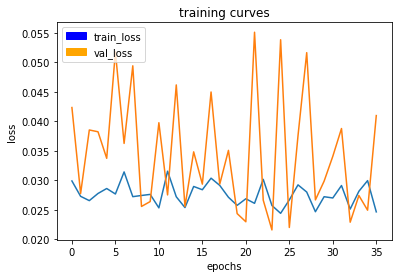

Epoch 00035: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0246 - val_loss: 0.0410
Epoch 37/100
34/35 [============================>.] - ETA: 0s - loss: 0.0285

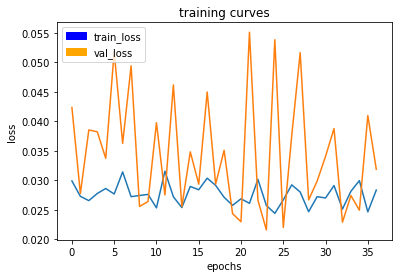

Epoch 00036: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0283 - val_loss: 0.0319
Epoch 38/100
34/35 [============================>.] - ETA: 0s - loss: 0.0263

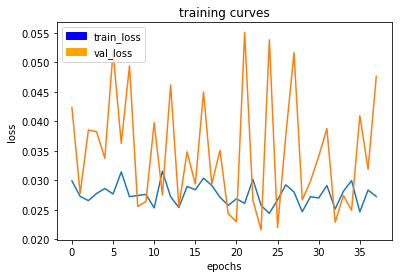

Epoch 00037: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0476
Epoch 39/100
34/35 [============================>.] - ETA: 0s - loss: 0.0254

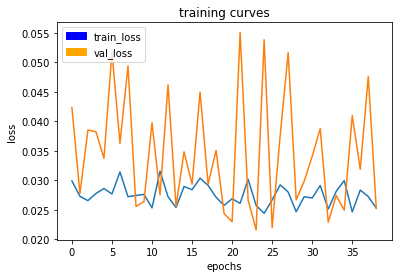


Epoch 00038: reducing learning rate to 0.0002867199946194887.
Epoch 00038: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0253 - val_loss: 0.0252
Epoch 40/100
34/35 [============================>.] - ETA: 0s - loss: 0.0246

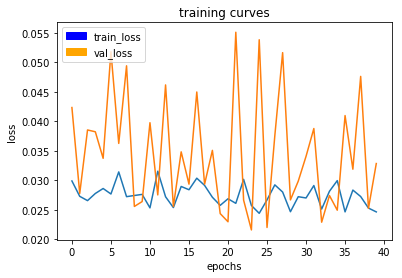

Epoch 00039: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0246 - val_loss: 0.0328
Epoch 41/100
34/35 [============================>.] - ETA: 0s - loss: 0.0271

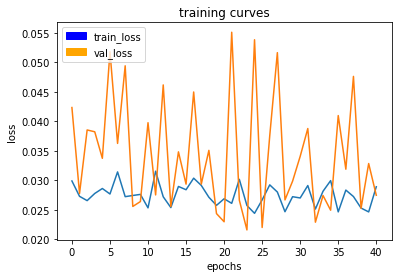

Epoch 00040: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0289 - val_loss: 0.0275
Epoch 42/100
34/35 [============================>.] - ETA: 0s - loss: 0.0258

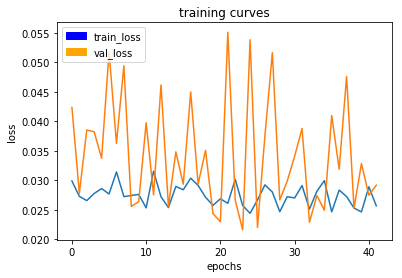

Epoch 00041: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0257 - val_loss: 0.0292
Epoch 43/100
34/35 [============================>.] - ETA: 0s - loss: 0.0251

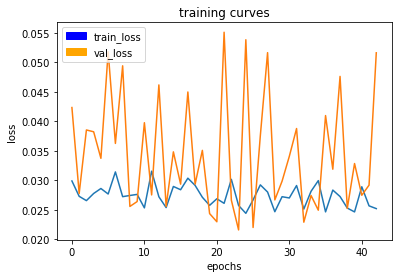

Epoch 00042: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0252 - val_loss: 0.0516
Epoch 44/100
34/35 [============================>.] - ETA: 0s - loss: 0.0272

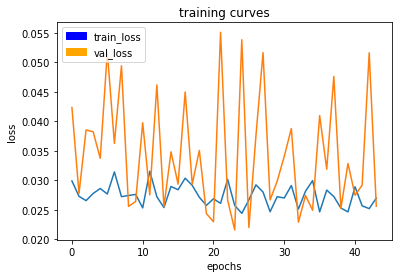

Epoch 00043: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0270 - val_loss: 0.0256
Epoch 45/100
34/35 [============================>.] - ETA: 0s - loss: 0.0233

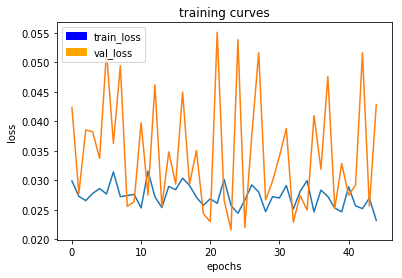

Epoch 00044: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0232 - val_loss: 0.0428
Epoch 46/100
34/35 [============================>.] - ETA: 0s - loss: 0.0267

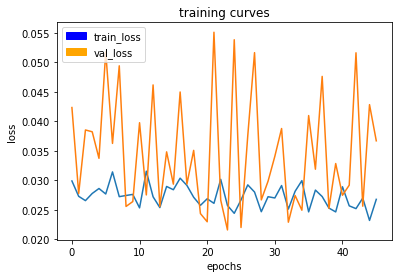


Epoch 00045: reducing learning rate to 0.00014335999730974436.
Epoch 00045: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0268 - val_loss: 0.0367
Epoch 47/100
34/35 [============================>.] - ETA: 0s - loss: 0.0285

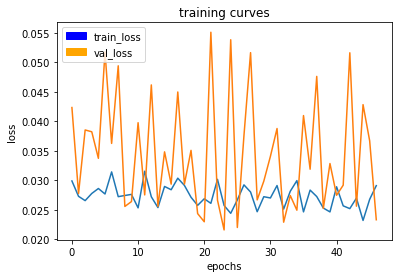

Epoch 00046: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0291 - val_loss: 0.0233
Epoch 48/100
34/35 [============================>.] - ETA: 0s - loss: 0.0238

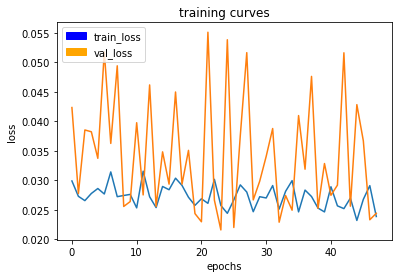

Epoch 00047: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0239 - val_loss: 0.0244
Epoch 49/100
34/35 [============================>.] - ETA: 0s - loss: 0.0255

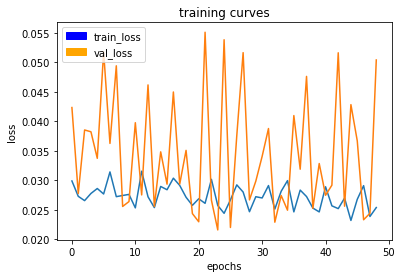

Epoch 00048: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0254 - val_loss: 0.0504
Epoch 50/100
34/35 [============================>.] - ETA: 0s - loss: 0.0272

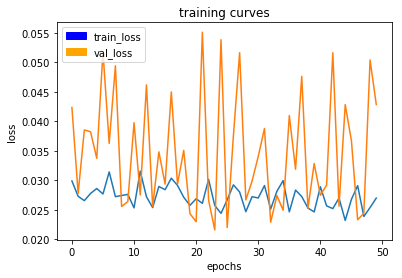

Epoch 00049: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0270 - val_loss: 0.0428
Epoch 51/100
34/35 [============================>.] - ETA: 0s - loss: 0.0253

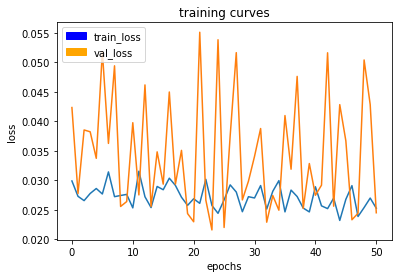

Epoch 00050: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0253 - val_loss: 0.0245
Epoch 52/100
34/35 [============================>.] - ETA: 0s - loss: 0.0287

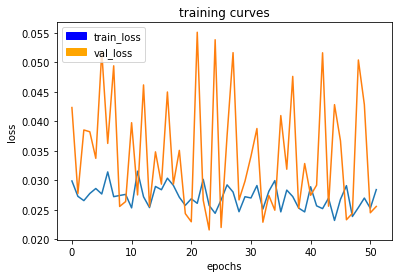

Epoch 00051: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0284 - val_loss: 0.0256
Epoch 53/100
34/35 [============================>.] - ETA: 0s - loss: 0.0253

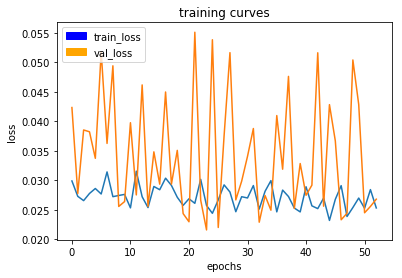


Epoch 00052: reducing learning rate to 7.167999865487218e-05.
Epoch 00052: val_loss did not improve
35/35 [==============================] - 25s - loss: 0.0253 - val_loss: 0.0268
Epoch 54/100
34/35 [============================>.] - ETA: 0s - loss: 0.0282

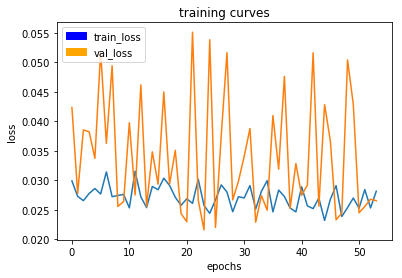

Epoch 00053: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0281 - val_loss: 0.0265
Epoch 55/100
34/35 [============================>.] - ETA: 0s - loss: 0.0274

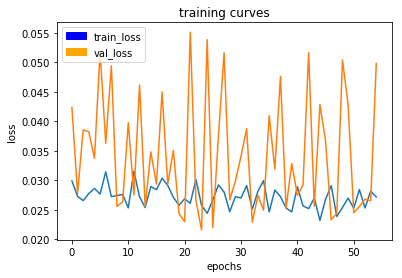

Epoch 00054: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0498
Epoch 56/100
34/35 [============================>.] - ETA: 0s - loss: 0.0248

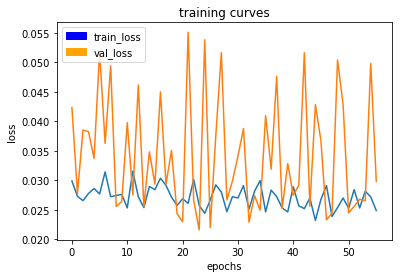

Epoch 00055: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0249 - val_loss: 0.0298
Epoch 57/100
34/35 [============================>.] - ETA: 0s - loss: 0.0253

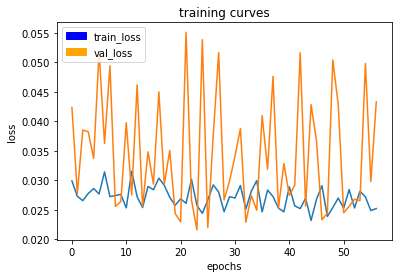

Epoch 00056: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0252 - val_loss: 0.0433
Epoch 58/100
34/35 [============================>.] - ETA: 0s - loss: 0.0261

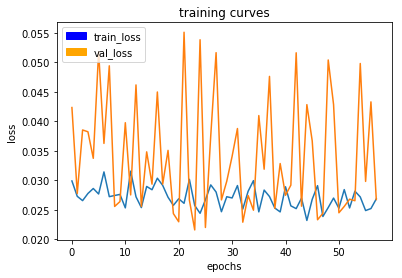

Epoch 00057: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0268 - val_loss: 0.0267
Epoch 59/100
34/35 [============================>.] - ETA: 0s - loss: 0.0249

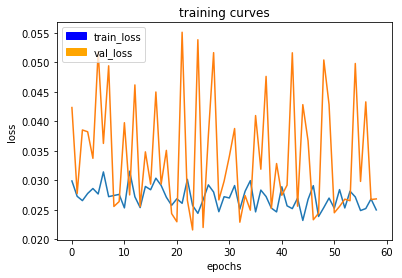

Epoch 00058: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0250 - val_loss: 0.0268
Epoch 60/100
34/35 [============================>.] - ETA: 0s - loss: 0.0247

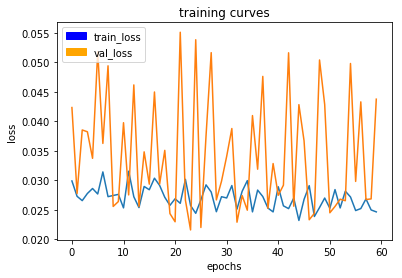


Epoch 00059: reducing learning rate to 3.583999932743609e-05.
Epoch 00059: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0246 - val_loss: 0.0438
Epoch 61/100
34/35 [============================>.] - ETA: 0s - loss: 0.0276

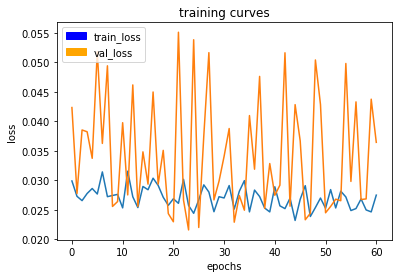

Epoch 00060: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0274 - val_loss: 0.0364
Epoch 62/100
34/35 [============================>.] - ETA: 0s - loss: 0.0275

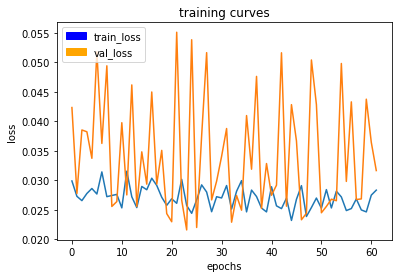

Epoch 00061: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0283 - val_loss: 0.0316
Epoch 63/100
34/35 [============================>.] - ETA: 0s - loss: 0.0272

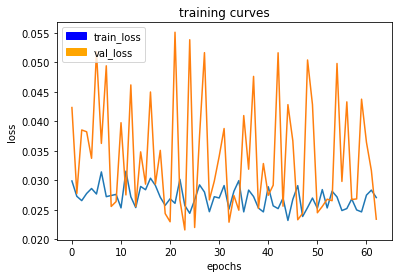

Epoch 00062: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0271 - val_loss: 0.0234
Epoch 64/100
34/35 [============================>.] - ETA: 0s - loss: 0.0238

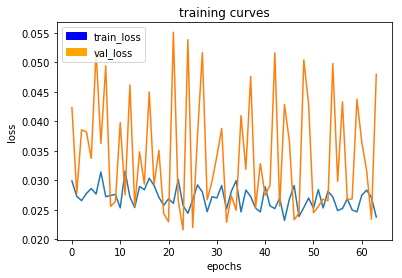

Epoch 00063: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0238 - val_loss: 0.0480
Epoch 65/100
34/35 [============================>.] - ETA: 0s - loss: 0.0254

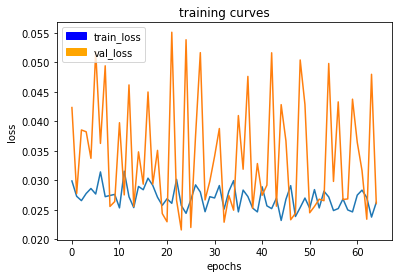

Epoch 00064: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0262 - val_loss: 0.0261
Epoch 66/100
34/35 [============================>.] - ETA: 0s - loss: 0.0267

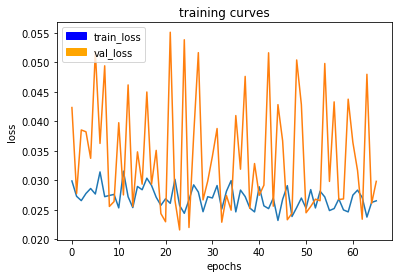

Epoch 00065: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0265 - val_loss: 0.0298
Epoch 67/100
34/35 [============================>.] - ETA: 0s - loss: 0.0233

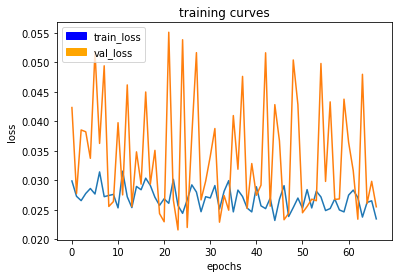


Epoch 00066: reducing learning rate to 1.7919999663718045e-05.
Epoch 00066: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0234 - val_loss: 0.0255
Epoch 68/100
34/35 [============================>.] - ETA: 0s - loss: 0.0262

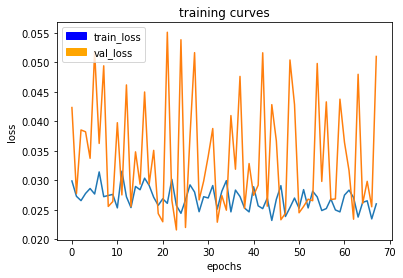

Epoch 00067: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0260 - val_loss: 0.0510
Epoch 69/100
34/35 [============================>.] - ETA: 0s - loss: 0.0277

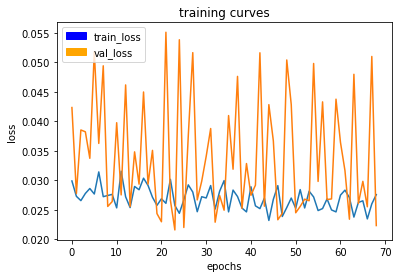

Epoch 00068: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0276 - val_loss: 0.0223
Epoch 70/100
34/35 [============================>.] - ETA: 0s - loss: 0.0266

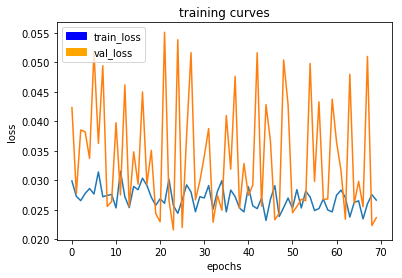

Epoch 00069: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0266 - val_loss: 0.0237
Epoch 71/100
34/35 [============================>.] - ETA: 0s - loss: 0.0240

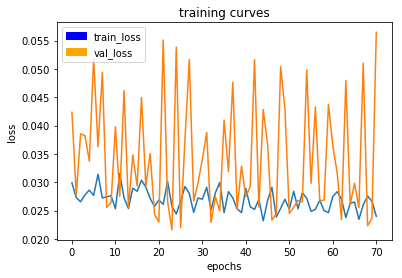

Epoch 00070: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0240 - val_loss: 0.0565
Epoch 72/100
34/35 [============================>.] - ETA: 0s - loss: 0.0236

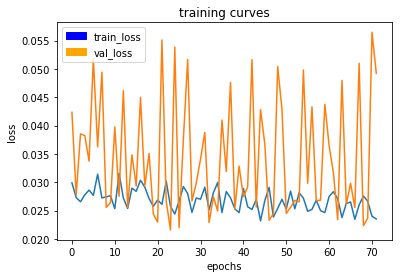

Epoch 00071: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0235 - val_loss: 0.0492
Epoch 73/100
34/35 [============================>.] - ETA: 0s - loss: 0.0275

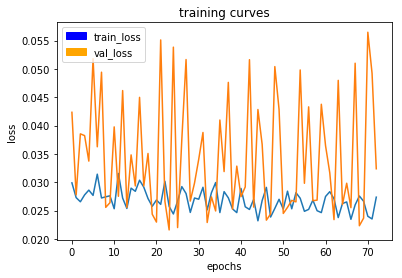

Epoch 00072: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0273 - val_loss: 0.0324
Epoch 74/100
34/35 [============================>.] - ETA: 0s - loss: 0.0284

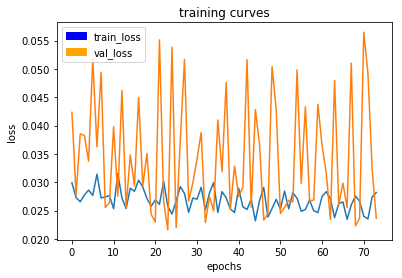


Epoch 00073: reducing learning rate to 8.959999831859022e-06.
Epoch 00073: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0282 - val_loss: 0.0236
Epoch 75/100
34/35 [============================>.] - ETA: 0s - loss: 0.0248

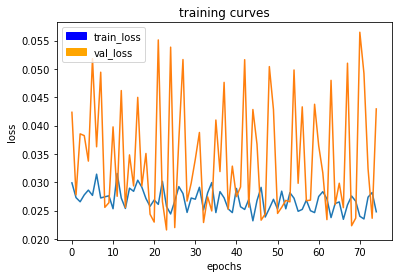

Epoch 00074: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0248 - val_loss: 0.0429
Epoch 76/100
34/35 [============================>.] - ETA: 0s - loss: 0.0238

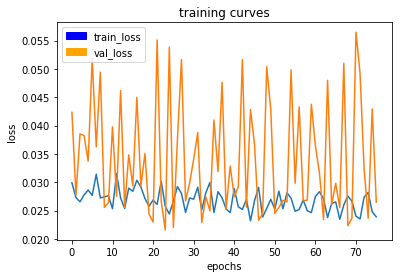

Epoch 00075: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0239 - val_loss: 0.0265
Epoch 77/100
34/35 [============================>.] - ETA: 0s - loss: 0.0298

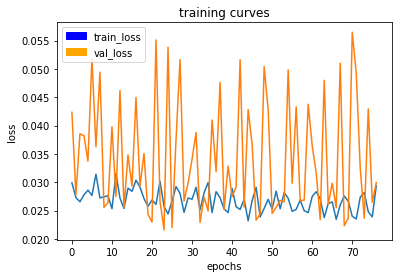

Epoch 00076: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0294 - val_loss: 0.0299
Epoch 78/100
34/35 [============================>.] - ETA: 0s - loss: 0.0251

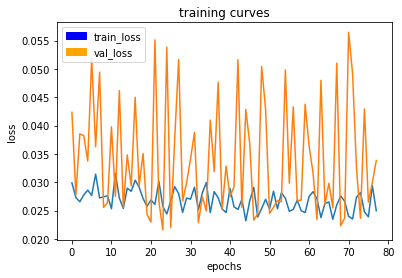

Epoch 00077: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0250 - val_loss: 0.0338
Epoch 79/100
34/35 [============================>.] - ETA: 0s - loss: 0.0284

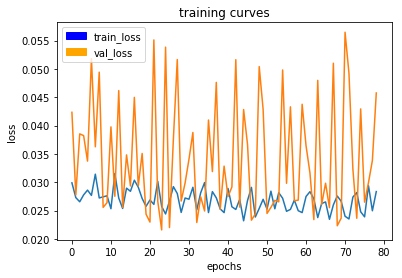

Epoch 00078: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0283 - val_loss: 0.0457
Epoch 80/100
34/35 [============================>.] - ETA: 0s - loss: 0.0270

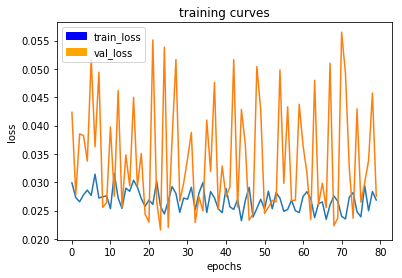

Epoch 00079: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0269 - val_loss: 0.0275
Epoch 81/100
34/35 [============================>.] - ETA: 0s - loss: 0.0234

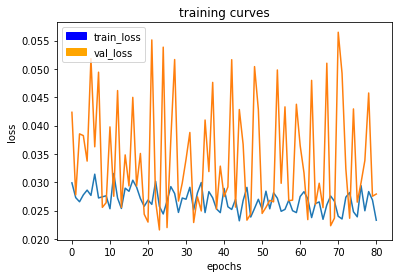


Epoch 00080: reducing learning rate to 4.479999915929511e-06.
Epoch 00080: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0233 - val_loss: 0.0279
Epoch 82/100
34/35 [============================>.] - ETA: 0s - loss: 0.0273

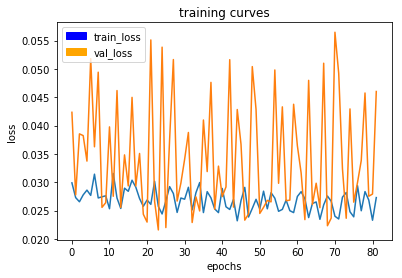

Epoch 00081: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0273 - val_loss: 0.0460
Epoch 83/100
34/35 [============================>.] - ETA: 0s - loss: 0.0244

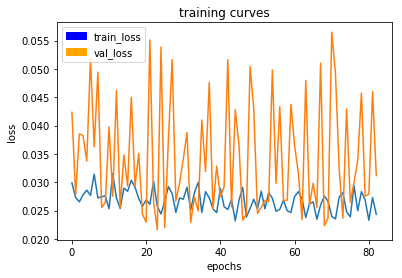

Epoch 00082: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0243 - val_loss: 0.0312
Epoch 84/100
34/35 [============================>.] - ETA: 0s - loss: 0.0271

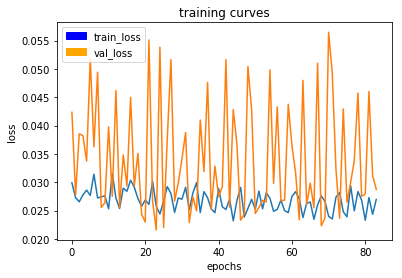

Epoch 00083: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0270 - val_loss: 0.0287
Epoch 85/100
34/35 [============================>.] - ETA: 0s - loss: 0.0262

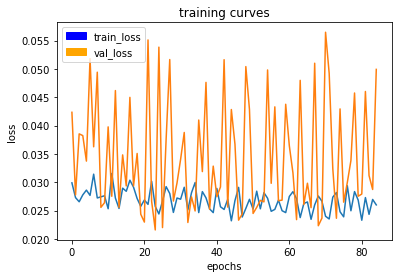

Epoch 00084: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0260 - val_loss: 0.0499
Epoch 86/100
34/35 [============================>.] - ETA: 0s - loss: 0.0249

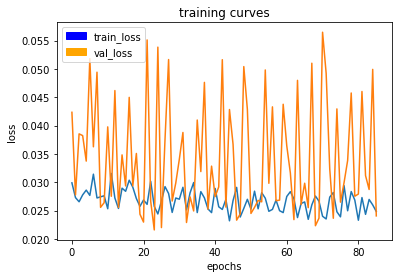

Epoch 00085: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0248 - val_loss: 0.0241
Epoch 87/100
34/35 [============================>.] - ETA: 0s - loss: 0.0257

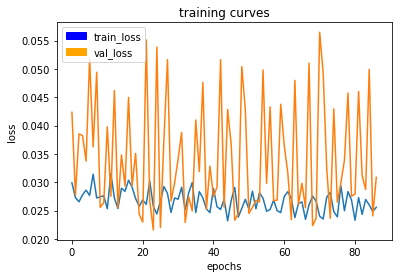

Epoch 00086: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0256 - val_loss: 0.0309
Epoch 88/100
34/35 [============================>.] - ETA: 0s - loss: 0.0259

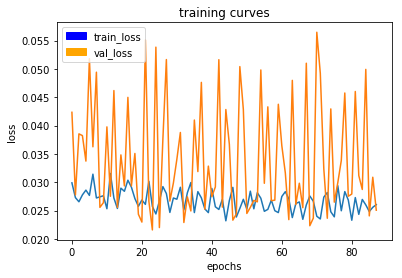


Epoch 00087: reducing learning rate to 2.2399999579647556e-06.
Epoch 00087: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0260 - val_loss: 0.0251
Epoch 89/100
34/35 [============================>.] - ETA: 0s - loss: 0.0281

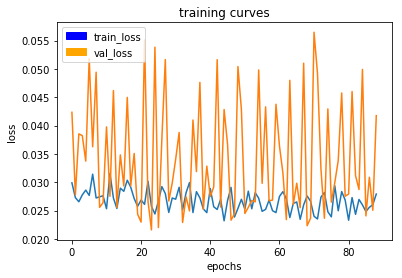

Epoch 00088: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0279 - val_loss: 0.0418
Epoch 90/100
34/35 [============================>.] - ETA: 0s - loss: 0.0252

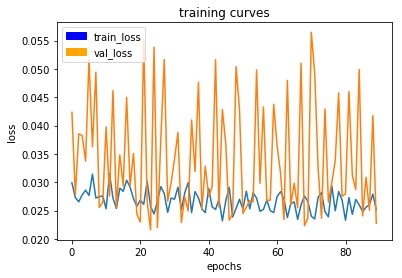

Epoch 00089: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0251 - val_loss: 0.0227
Epoch 91/100
34/35 [============================>.] - ETA: 0s - loss: 0.0282

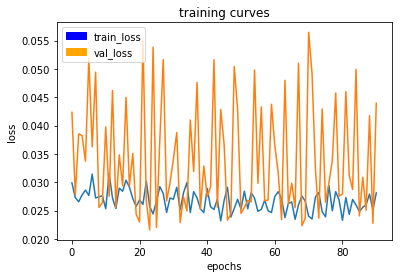

Epoch 00090: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0281 - val_loss: 0.0440
Epoch 92/100
34/35 [============================>.] - ETA: 0s - loss: 0.0238

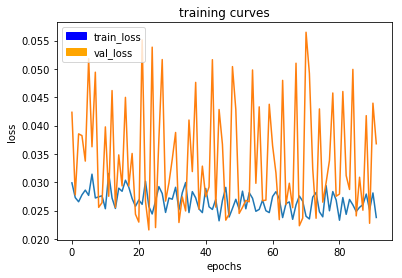

Epoch 00091: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0238 - val_loss: 0.0368
Epoch 93/100
34/35 [============================>.] - ETA: 0s - loss: 0.0266

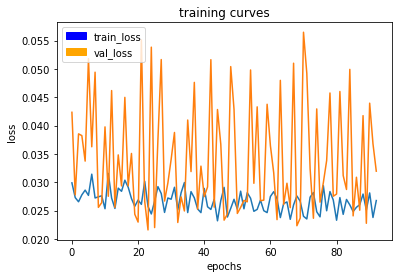

Epoch 00092: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0268 - val_loss: 0.0319
Epoch 94/100
34/35 [============================>.] - ETA: 0s - loss: 0.0249

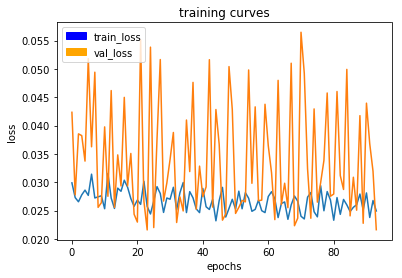

Epoch 00093: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0249 - val_loss: 0.0216
Epoch 95/100
34/35 [============================>.] - ETA: 0s - loss: 0.0268

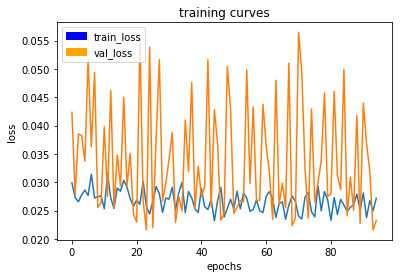


Epoch 00094: reducing learning rate to 1.1199999789823778e-06.
Epoch 00094: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0272 - val_loss: 0.0232
Epoch 96/100
34/35 [============================>.] - ETA: 0s - loss: 0.0260

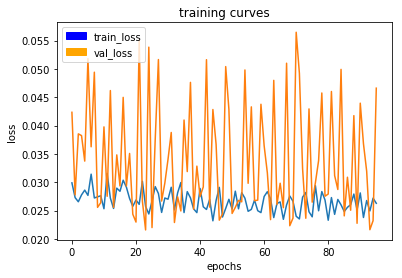

Epoch 00095: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0263 - val_loss: 0.0466
Epoch 97/100
34/35 [============================>.] - ETA: 0s - loss: 0.0253

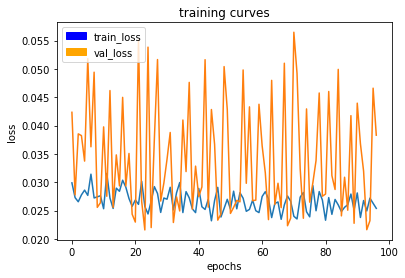

Epoch 00096: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0254 - val_loss: 0.0383
Epoch 98/100
34/35 [============================>.] - ETA: 0s - loss: 0.0271

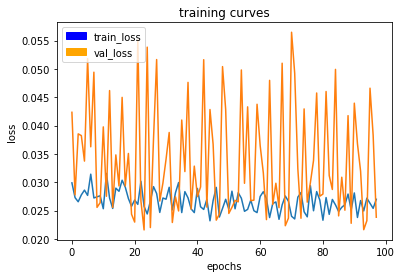

Epoch 00097: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0270 - val_loss: 0.0238
Epoch 99/100
34/35 [============================>.] - ETA: 0s - loss: 0.0252

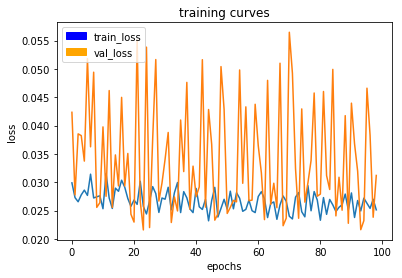

Epoch 00098: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0251 - val_loss: 0.0312
Epoch 100/100
34/35 [============================>.] - ETA: 0s - loss: 0.0271

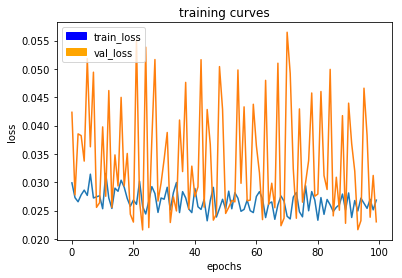

Epoch 00099: val_loss did not improve
35/35 [==============================] - 24s - loss: 0.0268 - val_loss: 0.0230


In [171]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

# Define the Keras model and compile it for training
#model = models.Model(inputs=inputs, outputs=output_layer)

#model.compile(optimizer=keras.optimizers.Adam(lr=learning_rate, decay=decay_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

callbacks = []
callbacks.append(plotting_tools.LoggerPlotter())
#callbacks.append(EarlyStopping(monitor='val_loss', patience=10))
callbacks.append(ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, verbose=1))
#callbacks.append(TensorBoard(log_dir=os.path.join('..', 'logs')))
callbacks.append(ModelCheckpoint('../model/{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True))

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [216]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model, weight_file_name)

## Prediction <a id='prediction'></a>

Now that you have your model trained and saved, you can make predictions on your validation dataset. These predictions can be compared to the mask images, which are the ground truth labels, to evaluate how well your model is doing under different conditions.

There are three different predictions available from the helper code provided:
- **patrol_with_targ**: Test how well the network can detect the hero from a distance.
- **patrol_non_targ**: Test how often the network makes a mistake and identifies the wrong person as the target.
- **following_images**: Test how well the network can identify the target while following them.

In [205]:
#model.save('../model/final0.407.hdf5')
model = models.load_model('../model/final0.407.hdf5')

In [118]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

weight_file_name = 'model_weights'
model = model_tools.load_network(weight_file_name)


The following cell will write predictions to files and return paths to the appropriate directories.
The `run_num` parameter is used to define or group all the data for a particular model run. You can change it for different runs. For example, 'run_1', 'run_2' etc.

In [206]:
run_num = 'run_1'

val_with_targ, pred_with_targ = model_tools.write_predictions_grade_set(model,
                                        run_num,'patrol_with_targ', 'sample_evaluation_data') 

val_no_targ, pred_no_targ = model_tools.write_predictions_grade_set(model, 
                                        run_num,'patrol_non_targ', 'sample_evaluation_data') 

val_following, pred_following = model_tools.write_predictions_grade_set(model,
                                        run_num,'following_images', 'sample_evaluation_data')

Now lets look at your predictions, and compare them to the ground truth labels and original images.
Run each of the following cells to visualize some sample images from the predictions in the validation set.

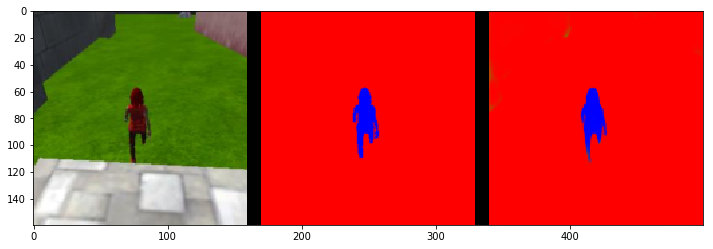

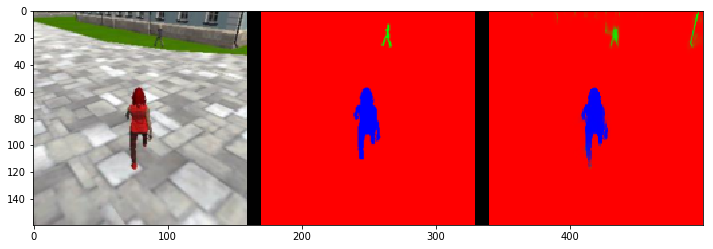

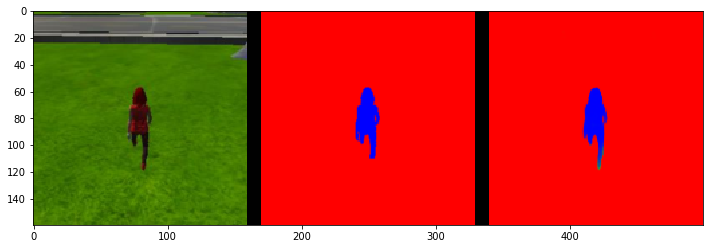

In [207]:
# images while following the target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','following_images', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
    

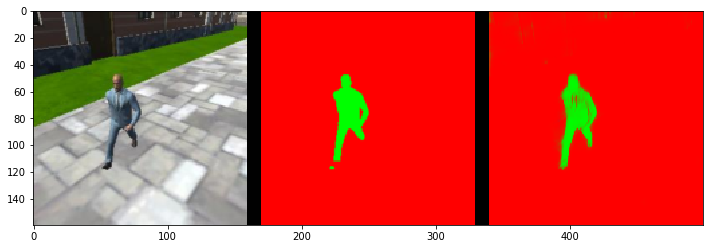

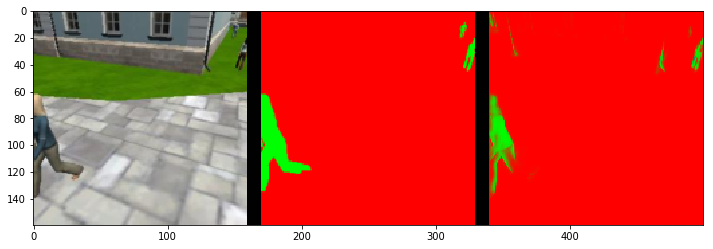

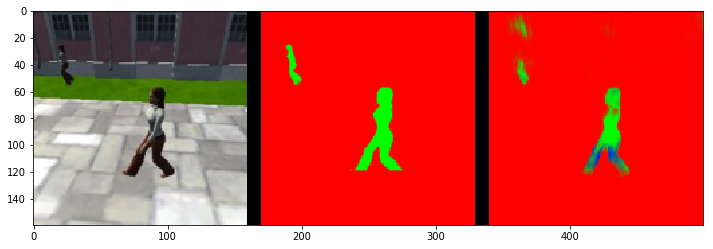

In [208]:
# images while at patrol without target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_non_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)
 

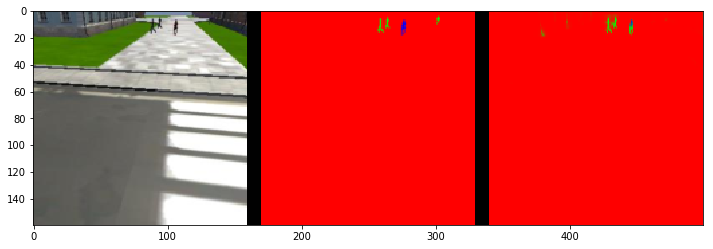

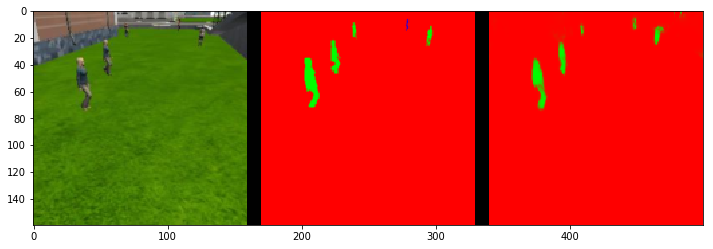

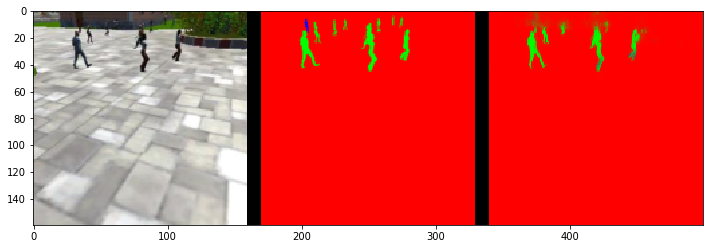

In [209]:
   
# images while at patrol with target
im_files = plotting_tools.get_im_file_sample('sample_evaluation_data','patrol_with_targ', run_num) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

## Evaluation <a id='evaluation'></a>
Evaluate your model! The following cells include several different scores to help you evaluate your model under the different conditions discussed during the Prediction step. 

In [210]:
# Scores for while the quad is following behind the target. 
true_pos1, false_pos1, false_neg1, iou1 = scoring_utils.score_run_iou(val_following, pred_following)

number of validation samples intersection over the union evaulated on 542
average intersection over union for background is 0.9936836670568034
average intersection over union for other people is 0.27866749177263345
average intersection over union for the hero is 0.8772417891445138
number true positives: 539, number false positives: 0, number false negatives: 0


In [211]:
# Scores for images while the quad is on patrol and the target is not visable
true_pos2, false_pos2, false_neg2, iou2 = scoring_utils.score_run_iou(val_no_targ, pred_no_targ)

number of validation samples intersection over the union evaulated on 270
average intersection over union for background is 0.9839702315666368
average intersection over union for other people is 0.6668971494261684
average intersection over union for the hero is 0.0
number true positives: 0, number false positives: 60, number false negatives: 0


In [212]:
# This score measures how well the neural network can detect the target from far away
true_pos3, false_pos3, false_neg3, iou3 = scoring_utils.score_run_iou(val_with_targ, pred_with_targ)

number of validation samples intersection over the union evaulated on 322
average intersection over union for background is 0.9958398622572022
average intersection over union for other people is 0.3850537528236625
average intersection over union for the hero is 0.21386212525481937
number true positives: 134, number false positives: 1, number false negatives: 167


In [213]:
# Sum all the true positives, etc from the three datasets to get a weight for the score
true_pos = true_pos1 + true_pos2 + true_pos3
false_pos = false_pos1 + false_pos2 + false_pos3
false_neg = false_neg1 + false_neg2 + false_neg3

weight = true_pos/(true_pos+false_neg+false_pos)
print(weight)

0.7469478357380688


In [214]:
# The IoU for the dataset that never includes the hero is excluded from grading
final_IoU = (iou1 + iou3)/2
print(final_IoU)

0.5455519571996665


In [215]:
# And the final grade score is 
final_score = final_IoU * weight
print(final_score)

0.40749885371295846
